# Decentmon data preparation

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from decmon.constants import *
from decmon.df_utils import *
from decmon.runner import *
from decmon.filter import *
from decmon.plotter import *

In [2]:
SUBDIR = 9

In [3]:
path = f"{INPUT_DIR}/{SUBDIR}"

f_df = [load_simulation_data(f"{path}/{i}_output.log") for i in PATTERNS]
f_df[0].head()

,formula_id,x,cent_trace_len,decent_trace_len,odecent_trace_len,cent_num_mess,decent_num_mess,odecent_num_mess,cent_size_mess,decent_size_mess,odecent_size_mess,cent_nb_progressions,decent_nb_progressions,odecent_nb_progressions,formula,trace
0,0,1,3,4,3,18,11,2,1.0,3.37,1.0,12,54,15,"Until (Var ""f"", Var ""e"")",{a| |c| | |f|g|h| } ; { |b|c| | |f|g|h| } ; {...
1,1,1,2,3,2,9,0,0,1.0,0.00,0.0,3,9,3,"Next (Var ""h"")",{a|b|c| |e|f| |h| } ; { |b|c| | | |g| | } ; {...
2,2,1,2,3,2,9,0,0,1.0,0.00,0.0,3,9,3,"Next (Var ""c"")",{ | |c| |e|f|g|h|i} ; {a| |c|d|e|f|g| | } ; {...
3,3,1,2,3,2,9,0,0,1.0,0.00,0.0,3,9,3,"Next (Var ""g"")",{a|b|c| |e| | | |i} ; { | | |d| |f|g|h|i} ; {...
4,4,1,2,3,2,9,8,0,1.0,2.22,0.0,4,14,4,"Glob (Var ""h"")",{ | | |d|e| | |h| } ; {a| |c|d|e|f| | |i} ; {...


In [4]:
strategies_f_df = [split_by_dictionary(f_df[i], STRATEGIES) for i in PATTERNS]

print(f"Datasets: {len(strategies_f_df)}. Strategies: {len(strategies_f_df[0])}. Single dataset Formulae:{len(strategies_f_df[0][0])}")
sep_strat_f_df = [pd.concat(strategies_f_df[i], ignore_index=True) for i in PATTERNS]
sep_strat_f_df[0].head()

Datasets: 8. Strategies: 3. Single dataset Formulae:5072


,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy
0,0,1,3,18,1.0,12,"Until (Var ""f"", Var ""e"")",{a| |c| | |f|g|h| } ; { |b|c| | |f|g|h| } ; {...,orchestration
1,1,1,2,9,1.0,3,"Next (Var ""h"")",{a|b|c| |e|f| |h| } ; { |b|c| | | |g| | } ; {...,orchestration
2,2,1,2,9,1.0,3,"Next (Var ""c"")",{ | |c| |e|f|g|h|i} ; {a| |c|d|e|f|g| | } ; {...,orchestration
3,3,1,2,9,1.0,3,"Next (Var ""g"")",{a|b|c| |e| | | |i} ; { | | |d| |f|g|h|i} ; {...,orchestration
4,4,1,2,9,1.0,4,"Glob (Var ""h"")",{ | | |d|e| | |h| } ; {a| |c|d|e|f| | |i} ; {...,orchestration


In [5]:
merged_metrics_df = [extract_metrics(sep_strat_f_df[i]) for i in PATTERNS]
merged_metrics_df[0].head()

,formula_id,strategy,value,metric
0,0,orchestration,3.0,trace_len
1,1,orchestration,2.0,trace_len
2,2,orchestration,2.0,trace_len
3,3,orchestration,2.0,trace_len
4,4,orchestration,2.0,trace_len


In [6]:
df_f_ops = [extract_ops(sep_strat_f_df[i]) for i in PATTERNS]
df_f_ops[0].head()

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,10,-6,-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,-7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


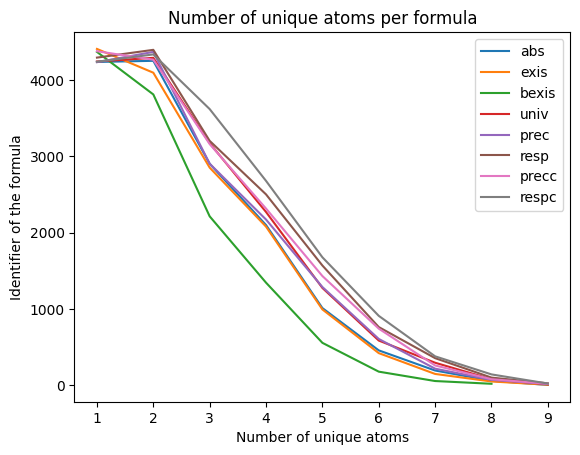

In [7]:
data = plot_atoms_variation(df_f_ops, SUBDIR)

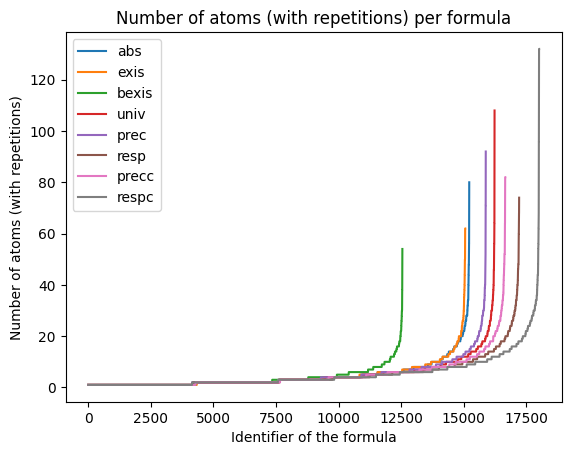

In [8]:
for i, d in enumerate(data):
    not_aggregated = d.transpose().sum()
    # not_aggregated.sort_index(key=not_aggregated.sum(1).get)
    # plt.plot()
    not_aggregated_2 = pd.DataFrame({'data': not_aggregated.sort_values()})
    # plt.plot(not_aggregated_2[0])
    not_aggregated_2 = not_aggregated_2.reset_index()
    plt.plot(not_aggregated_2['data'], label=f'{formula_patterns[i][0][1:]}')

plt.xlabel('Identifier of the formula')
plt.ylabel('Number of atoms (with repetitions)')
plt.title('Number of atoms (with repetitions) per formula')
plt.legend(loc='upper left')

In [18]:
data[0].transpose().sum()

4838     80
9910     80
14982    80
14484    60
9412     60
         ..
11871     1
5648      1
5649      1
5650      1
12052     1
Length: 15216, dtype: int64

## Plotting

In [9]:
# for i in patterns:
#     grid_plot = plot_grid_barplots(merged_metrics_df[i], grid_cell_field= 'metric',
#               y_axis = 'value', x_axis = 'strategy',
#               order = ['orchestration', 'migration', 'choreography'])

#grid_plot.savefig("output/out.png")

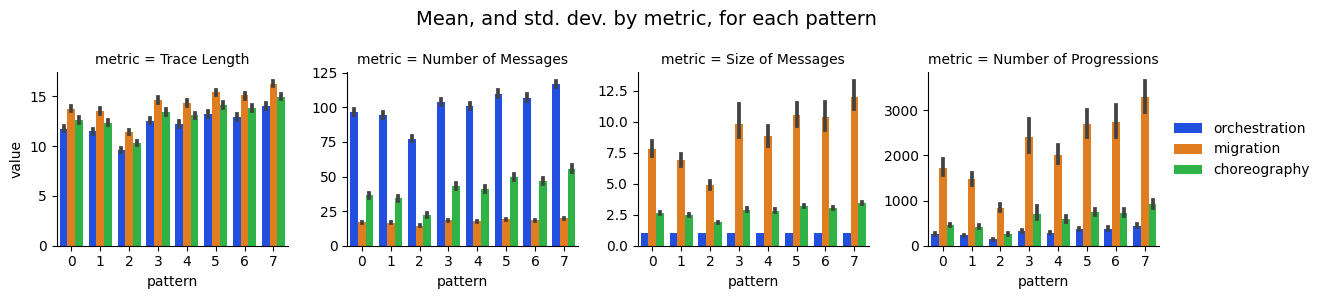

In [10]:
merged_metrics_dfp = prepare_with_pattern(merged_metrics_df)
plot = plot_metrics_by_patterns(merged_metrics_dfp)
plot.savefig(f"output/pattern_{SUBDIR}.png")
plot

In [11]:
expanded_f_df = [sep_strat_f_df[i].merge(df_f_ops[i], left_index=True, right_index=True) for i in PATTERNS]
expanded_f_df[0].head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,...,269,270,271,272,273,274,275,276,277,278
0,0,1,3,18,1.0,12,"Until (Var ""f"", Var ""e"")",{a| |c| | |f|g|h| } ; { |b|c| | |f|g|h| } ; {...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,9,1.0,3,"Next (Var ""h"")",{a|b|c| |e|f| |h| } ; { |b|c| | | |g| | } ; {...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,2,9,1.0,3,"Next (Var ""c"")",{ | |c| |e|f|g|h|i} ; {a| |c|d|e|f|g| | } ; {...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,2,9,1.0,3,"Next (Var ""g"")",{a|b|c| |e| | | |i} ; { | | |d| |f|g|h|i} ; {...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,2,9,1.0,4,"Glob (Var ""h"")",{ | | |d|e| | |h| } ; {a| |c|d|e|f| | |i} ; {...,orchestration,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
for i in PATTERNS:
    expanded_f_df[i].strategy = pd.Categorical(expanded_f_df[i].strategy)
    expanded_f_df[i]['strategy_id'] = expanded_f_df[i].strategy.cat.codes

full_scale_df_9 = pd.concat(expanded_f_df)
full_scale_df_9.head()

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,0,...,445,446,447,448,449,450,451,452,453,454
0,0,1,3,18,1.0,12,"Until (Var ""f"", Var ""e"")",{a| |c| | |f|g|h| } ; { |b|c| | |f|g|h| } ; {...,orchestration,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,9,1.0,3,"Next (Var ""h"")",{a|b|c| |e|f| |h| } ; { |b|c| | | |g| | } ; {...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,2,9,1.0,3,"Next (Var ""c"")",{ | |c| |e|f|g|h|i} ; {a| |c|d|e|f|g| | } ; {...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,2,9,1.0,3,"Next (Var ""g"")",{a|b|c| |e| | | |i} ; { | | |d| |f|g|h|i} ; {...,orchestration,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,2,9,1.0,4,"Glob (Var ""h"")",{ | | |d|e| | |h| } ; {a| |c|d|e|f| | |i} ; {...,orchestration,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
merged_metrics_dfp[0]

,index,strategy,value,metric,pattern
0,0,orchestration,3.0,trace_len,0
1,1,orchestration,2.0,trace_len,0
2,2,orchestration,2.0,trace_len,0
3,3,orchestration,2.0,trace_len,0
4,4,orchestration,2.0,trace_len,0
...,...,...,...,...,...
60859,15211,choreography,8560.0,nb_progressions,0
60860,15212,choreography,284.0,nb_progressions,0
60861,15213,choreography,649.0,nb_progressions,0
60862,15214,choreography,3495.0,nb_progressions,0


In [14]:
test = pd.concat(merged_metrics_dfp)
test

,index,strategy,value,metric,pattern
0,0,orchestration,3.0,trace_len,0
1,1,orchestration,2.0,trace_len,0
2,2,orchestration,2.0,trace_len,0
3,3,orchestration,2.0,trace_len,0
4,4,orchestration,2.0,trace_len,0
...,...,...,...,...,...
72019,18001,choreography,2709.0,nb_progressions,7
72020,18002,choreography,1709.0,nb_progressions,7
72021,18003,choreography,1249.0,nb_progressions,7
72022,18004,choreography,2663.0,nb_progressions,7
